In [1]:
!pip install ccxt
!pip install ta
!pip install mplfinance
import ccxt
import pandas as pd
import numpy as np
import talib as ta
import ta.trend as trend
import ta.momentum as momentum

# Initialize exchange (Binance example) 
exchange = ccxt.binanceus()
symbol = 'BTC/USDT'  # Replace with desired trading pair
timeframe = '4h'  # Set desired timeframe

# Fetch OHLCV data
def fetch_data(symbol, timeframe, limit=300):
    ohlcv = exchange.fetch_ohlcv(symbol, timeframe, limit=limit)
    df = pd.DataFrame(ohlcv, columns=['timestamp', 'open', 'high', 'low', 'close', 'volume'])
    df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
    return df

# Convert to Heikin Ashi candles
def heikin_ashi(df):
    ha_df = df.copy()
    ha_df['ha_close'] = (df['open'] + df['high'] + df['low'] + df['close']) / 4
    ha_df['ha_open'] = (df['open'].shift(1) + df['close'].shift(1)) / 2
    ha_df.iloc[0, ha_df.columns.get_loc('ha_open')] = (df['open'].iloc[0] + df['close'].iloc[0]) / 2
    ha_df['ha_high'] = ha_df[['ha_open', 'ha_close', 'high']].max(axis=1)
    ha_df['ha_low'] = ha_df[['ha_open', 'ha_close', 'low']].min(axis=1)
    return ha_df

# Calculate EMA 200
def calculate_ema(df):
    df['ema_200'] = trend.ema_indicator(df['close'], window=200)
    return df

# Calculate Stochastic RSI
def calculate_stoch_rsi(df):
    df['stoch_rsi_k'] = momentum.stochrsi_k(df['close'], window=14)
    df['stoch_rsi_d'] = momentum.stochrsi_d(df['close'], window=14)
    return df

# Define trading strategy
def apply_strategy(df):
    df = heikin_ashi(df)
    df = calculate_ema(df)
    df = calculate_stoch_rsi(df)
    
    df['position'] = 'HOLD'
    
    for i in range(1, len(df)):
        ha_candle = df.iloc[i]
        prev_ha_candle = df.iloc[i - 1]
        
        is_above_ema = ha_candle['ha_close'] > ha_candle['ema_200']
        is_below_ema = ha_candle['ha_close'] < ha_candle['ema_200']
        
        stoch_oversold = ha_candle['stoch_rsi_k'] < 20 and ha_candle['stoch_rsi_d'] < 20
        stoch_overbought = ha_candle['stoch_rsi_k'] > 80 and ha_candle['stoch_rsi_d'] > 80
        stoch_cross_up = ha_candle['stoch_rsi_k'] > ha_candle['stoch_rsi_d'] and df.iloc[i - 1]['stoch_rsi_k'] <= df.iloc[i - 1]['stoch_rsi_d']
        stoch_cross_down = ha_candle['stoch_rsi_k'] < ha_candle['stoch_rsi_d'] and df.iloc[i - 1]['stoch_rsi_k'] >= df.iloc[i - 1]['stoch_rsi_d']
        
        is_bullish_candle = ha_candle['ha_close'] > ha_candle['ha_open'] and ha_candle['ha_low'] == ha_candle['ha_open']
        is_bearish_candle = ha_candle['ha_close'] < ha_candle['ha_open'] and ha_candle['ha_high'] == ha_candle['ha_open']
        
        # Long Entry
        if is_above_ema and stoch_oversold and stoch_cross_up and is_bullish_candle:
            df.at[i, 'position'] = 'LONG'
        
        # Short Entry
        elif is_below_ema and stoch_overbought and stoch_cross_down and is_bearish_candle:
            df.at[i, 'position'] = 'SHORT'
    
    return df

# Execute
df = fetch_data(symbol, timeframe)
df = apply_strategy(df)

# Display trading signals
print(df[['timestamp', 'ha_close', 'ema_200', 'stoch_rsi_k', 'stoch_rsi_d', 'position']].tail(20))
df[['timestamp', 'ha_close', 'ema_200', 'stoch_rsi_k', 'stoch_rsi_d', 'position']].to_csv("debug_output.csv", index=False)


              timestamp    ha_close       ema_200  stoch_rsi_k  stoch_rsi_d  \
280 2025-04-24 20:00:00  93614.5975  85315.430882     0.286280     0.194578   
281 2025-04-25 00:00:00  93617.6475  85394.267987     0.228805     0.237662   
282 2025-04-25 04:00:00  93435.5925  85477.370395     0.185645     0.233577   
283 2025-04-25 08:00:00  94099.8950  85567.594173     0.180929     0.198460   
284 2025-04-25 12:00:00  94861.8950  85663.517216     0.383365     0.249980   
285 2025-04-25 16:00:00  95123.7525  85759.072965     0.572661     0.378985   
286 2025-04-25 20:00:00  94959.3050  85847.582587     0.548587     0.501538   
287 2025-04-26 00:00:00  94820.6025  85936.662959     0.435979     0.519076   
288 2025-04-26 04:00:00  94739.9575  86024.041039     0.301606     0.428724   
289 2025-04-26 08:00:00  94394.3850  86104.773168     0.216192     0.317926   
290 2025-04-26 12:00:00  94215.9100  86186.488261     0.139592     0.219130   
291 2025-04-26 16:00:00  94251.9375  86266.955741   

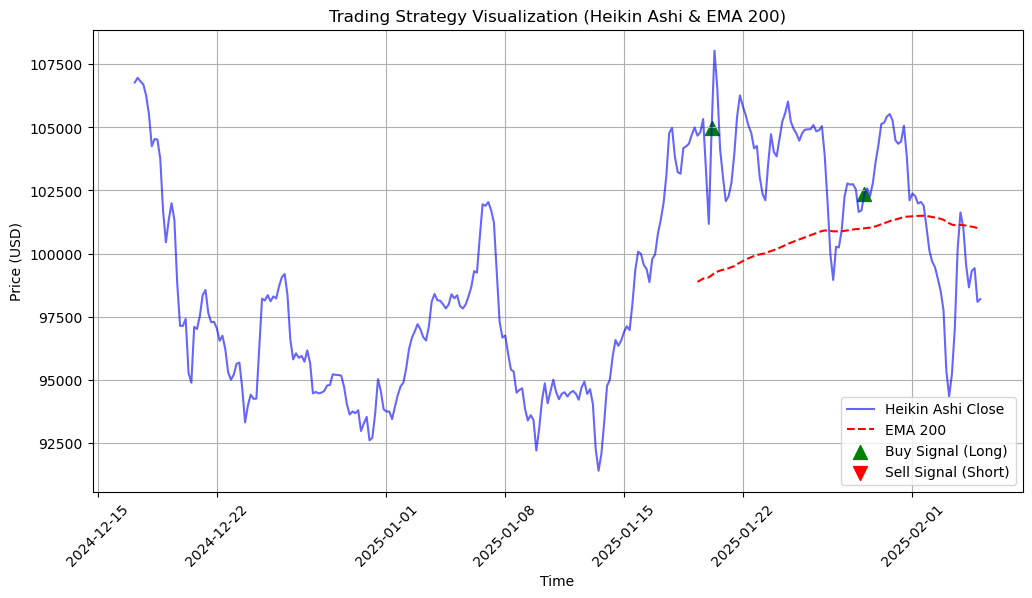

In [2]:
import matplotlib.pyplot as plt
import mplfinance as mpf

# Function to visualize the strategy with Heikin Ashi, EMA 200, and trade signals
def plot_trading_chart(df):
    df_plot = df.copy()

    # Set timestamp as index for plotting
    df_plot.set_index('timestamp', inplace=True)

    # Define figure layout
    fig, ax = plt.subplots(figsize=(12, 6))

    # Plot Heikin Ashi Close Prices
    ax.plot(df_plot.index, df_plot['ha_close'], color='blue', label="Heikin Ashi Close", alpha=0.6)

    # Plot EMA 200
    ax.plot(df_plot.index, df_plot['ema_200'], color='red', linestyle="dashed", label="EMA 200")

    # Plot Buy and Sell signals
    long_signals = df_plot[df_plot['position'] == "LONG"]
    short_signals = df_plot[df_plot['position'] == "SHORT"]

    ax.scatter(long_signals.index, long_signals['ha_close'], marker="^", color="green", label="Buy Signal (Long)", alpha=1, s=100)
    ax.scatter(short_signals.index, short_signals['ha_close'], marker="v", color="red", label="Sell Signal (Short)", alpha=1, s=100)

    # Labels and legend
    ax.set_title("Trading Strategy Visualization (Heikin Ashi & EMA 200)")
    ax.set_xlabel("Time")
    ax.set_ylabel("Price (USD)")
    ax.legend()
    ax.grid(True)

    # Show the plot
    plt.xticks(rotation=45)
    plt.show()

# Load the latest data
df = fetch_data(symbol, timeframe)
df = apply_strategy(df)

# Plot the trading strategy visualization
plot_trading_chart(df)
